
# Predicting NFL positions by exploring the effect of tree pruning on the accuracy and size of a decision tree classifier model

#### Olin R. Carty
#### Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


## Executive Summary

I am interested in the effect that pruning and depth limitation have on the size and accuracy of a decision tree classifier. Using data from the NFL combine, I trained a decision tree classifier model and selected a complexity paramter for minimal cost-complexity pruning that led to the highest accuracy of the model leading to a reduction in leaves from 973 to 120. I then went back to the initial tree and and tuned the max_depth hyperparameter, before again pruning the tree with minimal cost-complexity pruning leading to a final model with 69 leaves. Although my prediction accuracy dropped slightly (~1%) between the two pruned models, pre-tuning the max_depth hyperparameter before pruning decreased the final number of leaves in the tree by over 40%. With this data, this model can be used to determine the "ideal" position someone would play in the NFL, and in general the methodology can be used when creating decision trees as a way to create smaller trees without much loss in model accuracy.

## Import Packages

We will be using the following packages in our workflow.

In [1]:
import numpy as np                                      # for working with data arrays
import pandas as pd                                     # creating dataframe to work with
import pandas.plotting as pd_plot                       # matrix scatter plots from pandas
import matplotlib.pyplot as plt                         # for plotting
import seaborn as sns                                   # for matrix scatter plots

from sklearn.model_selection import train_test_split    # training and testing data split
from sklearn import tree                                # decision tree model
from sklearn.model_selection import GridSearchCV        # cross-validation model selection

## Load Data

The following workflow uses the .csv file 'nfl_combine_data_2012-2021.csv'. This is data was aggregated from https://nflcombineresults.com/nflcombinedata.php for the years 2012-2021. The data set is from the "expanded sortable table" however we will only be using the features that are in the "standard sortable table".

We will work with the following features:

* **POS** - player position (different positions will be discussed later on)
* **Height (in)** - player height (inches)
* **Weight (lbs)** - player weight (pounds)
* **40 yards** - 40 yard dash time (seconds)
* **Vert Leap (in)** - height of vertical jump (inches)
* **Broad Jump (in)** - distance of horizontal jump (inches)
* **Shuttle** - time to run 5 yards right, back 10 yards left, and then 5 yards right (seconds)
* **3Cone** - time to run between cones in a 'L' shaped pattern (seconds)

I chose to ignore 'hand size' and 'arm length' since player size is found in the 'height' and 'weight' categories. Manually looking through the data, the 'bench press' data is fairly sparse so is not included and there are only a few instances of 'Wonderlic' and '60Yd Shuttle' so these were ignored.

To simplify calling the data from pandas, the features have been renamed to not inclued spaces or parentheses:

* **POS** - position
* **Height (in)** - height
* **Weight (lbs)** - weight
* **40 yards** - 40yd
* **Vert Leap (in)** - vert_leap
* **Broad Jump (in)** - broad_jump
* **Shuttle** - shuttle
* **3Cone** - 3cone

```python
df = pd.read_csv(r"https://raw.githubusercontent.com/olincarty/machine_learning_project/main/nfl_combine_data_2012-2021.csv")
df = df.drop(df.columns[[0, 1, 2, 6, 7, 8, 10, 15]], axis = 1)        # drop unwanted columns, keeping only the columns listed above

# renaming columns as listed above
new_names = ['position','height','weight','40yd','vert_leap','broad_jump','shuttle','3cone']
for count, value in enumerate(df.columns):
    df = df.rename(columns={f'{value}': new_names[count]})
```

We can view the first few lines of data using:
```python
df.head()
```

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/olincarty/machine_learning_project/main/nfl_combine_data_2012-2021.csv')

In [3]:
df = df.drop(df.columns[[0, 1, 2, 6, 7, 8, 10, 15]], axis = 1)        # drop unwanted columns

new_names = ['position','height','weight','40yd','vert_leap','broad_jump','shuttle','3cone']

for count, value in enumerate(df.columns):                            # rename columns
    df = df.rename(columns={f'{value}': new_names[count]})
    
df.head()

,position,height,weight,40yd,vert_leap,broad_jump,shuttle,3cone
0,WR,74.00,210,4.59,39.0,132.0,4.38,7.04
1,CB,73.00,198,4.45,36.5,121.0,4.13,6.69
2,FS,71.75,191,4.58,34.5,119.0,4.33,6.98
3,OG,76.63,314,5.27,29.5,105.0,4.83,7.88
4,RB,67.50,179,4.65,36.0,113.0,4.42,7.04


As we can see, the 'position' variable contains a column of strings. The goal is to predict general positions based off of the other parameters. To begin working with the positions we want to do the following:
1. List the different positions in our DataFrame
```python
df['position'].value_counts()
```
2. Simplify the list by combining similar positions (we will replace the old position with a new position)
```python
df['position'] = df['position'].replace('pos_X', 'pos_Y')  # replaces 'pos_X' with 'pos_Y'
```
3. Give each position a number (to use for color coding in plots)
```python
df.insert(1, 'pos_num', df['position'])                  # inserts a copy 'position' column into DataFrame
df['pos_num'] = df['pos_num'].replace('pos_Y', number)   # replaces 'pos_Y' with a number
```

Going through the above workflow:
1. List the different positions in our DataFrame (I have included the count of each position as well)

In [4]:
df['position'].value_counts()        # list of positions and count of each position

WR     682
CB     518
RB     410
DT     389
DE     365
OT     343
OLB    325
OG     300
TE     269
QB     257
ILB    199
FS     177
SS     176
C      152
LB      91
FB      88
P       79
K       68
S       53
EDG     22
LS      20
OL      10
DL       4
DB       3
NT       1
Name: position, dtype: int64

Above we have a list of all the positions available in the data set. We are going to simplify the positions (especially on the defense) to consist of: <br>
1. **OL** - offensive line (OL, OT, C, OG) <br>
2. **QB** - quarterback <br>
3. **RB** - running back <br>
4. **WR** - wide receiver <br>
5. **TE** - tight end <br>
6. **DL** - defensive line (DL, NT, EDG, DE, DT) <br>
7. **LB** - linebacker (LB, ILB, OLB) <br>
8. **S** - safety (S, DB, SS, FS) <br>
9. **CB** - cornerback <br>
10. **K** - kicker <br>
11. **P** - punter <br>
12. **LS** - long snapper <br>
13. **FB** - full back <br>

2. Simplify the list by combining similar positions (we will replace the old position with a new position)

In [5]:
df['position'] = df['position'].replace('OL', 'OL')   # replaces 'OL' with 'OL'
df['position'] = df['position'].replace('OT', 'OL')   # replaces 'OT' with 'OL'
df['position'] = df['position'].replace('C', 'OL')    # ...
df['position'] = df['position'].replace('OG', 'OL')
df['position'] = df['position'].replace('QB', 'QB')
df['position'] = df['position'].replace('FB', 'FB')
df['position'] = df['position'].replace('RB', 'RB')
df['position'] = df['position'].replace('WR', 'WR')
df['position'] = df['position'].replace('TE', 'TE')
df['position'] = df['position'].replace('DL', 'DL')
df['position'] = df['position'].replace('NT', 'DL')
df['position'] = df['position'].replace('EDG', 'DL')
df['position'] = df['position'].replace('DE', 'DL')
df['position'] = df['position'].replace('DT', 'DL')
df['position'] = df['position'].replace('LB', 'LB')
df['position'] = df['position'].replace('ILB', 'LB')
df['position'] = df['position'].replace('OLB', 'LB')
df['position'] = df['position'].replace('S', 'S')
df['position'] = df['position'].replace('DB', 'S')
df['position'] = df['position'].replace('SS', 'S')
df['position'] = df['position'].replace('FS', 'S')
df['position'] = df['position'].replace('CB', 'CB')
df['position'] = df['position'].replace('K', 'K')
df['position'] = df['position'].replace('P', 'P')
df['position'] = df['position'].replace('LS', 'LS')

3. Give each position a number (to use for color coding in plots)

In [6]:
df.insert(1, 'pos_num', df['position'])                  # inserts a copy 'position' column into DataFrame

df['pos_num'] = df['pos_num'].replace('OL', 1)           # replaces 'OL' with 1
df['pos_num'] = df['pos_num'].replace('QB', 2)           # ...
df['pos_num'] = df['pos_num'].replace('RB', 3)
df['pos_num'] = df['pos_num'].replace('WR', 4)
df['pos_num'] = df['pos_num'].replace('TE', 5)
df['pos_num'] = df['pos_num'].replace('DL', 6)
df['pos_num'] = df['pos_num'].replace('LB', 7)
df['pos_num'] = df['pos_num'].replace('S', 8)
df['pos_num'] = df['pos_num'].replace('CB', 9)
df['pos_num'] = df['pos_num'].replace('K', 10)
df['pos_num'] = df['pos_num'].replace('P', 11)
df['pos_num'] = df['pos_num'].replace('LS', 12)
df['pos_num'] = df['pos_num'].replace('FB', 13)

View the first few rows

In [7]:
df.head()

,position,pos_num,height,weight,40yd,vert_leap,broad_jump,shuttle,3cone
0,WR,4,74.00,210,4.59,39.0,132.0,4.38,7.04
1,CB,9,73.00,198,4.45,36.5,121.0,4.13,6.69
2,S,8,71.75,191,4.58,34.5,119.0,4.33,6.98
3,OL,1,76.63,314,5.27,29.5,105.0,4.83,7.88
4,RB,3,67.50,179,4.65,36.0,113.0,4.42,7.04


We have now simplified our initial data set to contain the generalized positions and the measurements of interest.

Let's look at the list of positions we have and their counts

In [8]:
df['position'].value_counts()        # list of positions and count of each position

OL    805
DL    781
WR    682
LB    615
CB    518
RB    410
S     409
TE    269
QB    257
FB     88
P      79
K      68
LS     20
Name: position, dtype: int64

## Visualization of data
We have not removed any NaN values from the DataFrame yet, but we will still visualize the initial data to see if there are any visual outliers of data. Any noticeable outliers I will assume occur due to a misrecording of data or from an incomplete test.

First we will get a list of the features for future convenience.

In [9]:
features = []
count = 2
while count < len(df.columns):              # creating list of features in DataFrame
    features.append(df.columns[count])
    count += 1
    
print(features)

['height', 'weight', '40yd', 'vert_leap', 'broad_jump', 'shuttle', '3cone']


Visualizing data using the package pandas.plotting.scatter_matrix

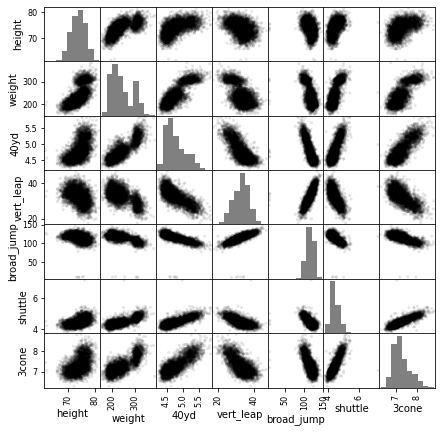

In [10]:
# Visualize data

pd_plot.scatter_matrix(df[features], alpha = 0.1,
                       figsize=(7, 7), color = 'black', hist_kwds={'color':['grey']})
plt.show()

Looking at the above scatter plots, we can see where we have some outlier values. We will change these outliers to NaN values with the assumption of the following outliers:

* height < 65 inches
* broad_jump < 50
* shuttle > 6

In [11]:
df.loc[(df.height < 65),'height'] = np.nan            # change all height values below 65 to NaN
df.loc[(df.broad_jump < 50),'broad_jump'] = np.nan    # change all broad jumps values below 50 to NaN
df.loc[(df.shuttle > 6),'shuttle'] = np.nan           # change all shuttle values avove 6 to NaN

We have added some NaN values into our data set now. In addition, since it is not required for athletes to do every physical test, we will have NaN values throughout this data set. To get rid of NaN values, we will simply use a **likewise deletion**. Within the data set, this will delete the entire row if any value in the row is listed as NaN. This is done as follows:

In [12]:
df = df.dropna()                            # delete any row that conains a NaN value - likewise deletion

Following this, we can do another poistion count as we did above:

In [13]:
df['position'].value_counts()               # list of positions and count of each position

OL    655
DL    624
WR    572
LB    486
CB    431
S     332
RB    329
TE    230
QB    194
FB     78
LS     13
P       4
K       1
Name: position, dtype: int64

From this, we can see that we have far further FB, P, K, and LS than other positions. Punters and kickers (P, K) are unsurprising as these postions often will not partake in the physical benchmarks during the combine. Long snappers (LS) are another very specialized position like kickers and punters. Finally, fullbacks (FB) have fallen out of favor over the last decade or so which explains the lack of fullbacks at the combine. <br>
With this information, we will drop all the FB, P, K, and LS positions from our model using:
```python
df.drop(df.loc[df['position']=='X'].index, inplace=True)    # deletes all instances of position X
```
This will leave us with the data set we hope to work with for the supervised learning clustering.

In [14]:
df.drop(df.loc[df['position']=='FB'].index, inplace=True) # deletes all instances of position FB
df.drop(df.loc[df['position']=='P'].index, inplace=True)  # ...
df.drop(df.loc[df['position']=='K'].index, inplace=True)
df.drop(df.loc[df['position']=='LS'].index, inplace=True)

Let's revisualize the data with the outliers and other data removed.

We previously used pandas.plotting to view a pair plot of our data. Now lets try viewing the data distribution using the seaborn package:
```python
sns.pairplot(df[['position'] + features], hue='position')     # pairplot of data colored by position
```
This will allow us to easily color points based on their position (hue='position'). In addtion, remember that we previously made the 'features' list so we could easily call the parameters within our DataFrame

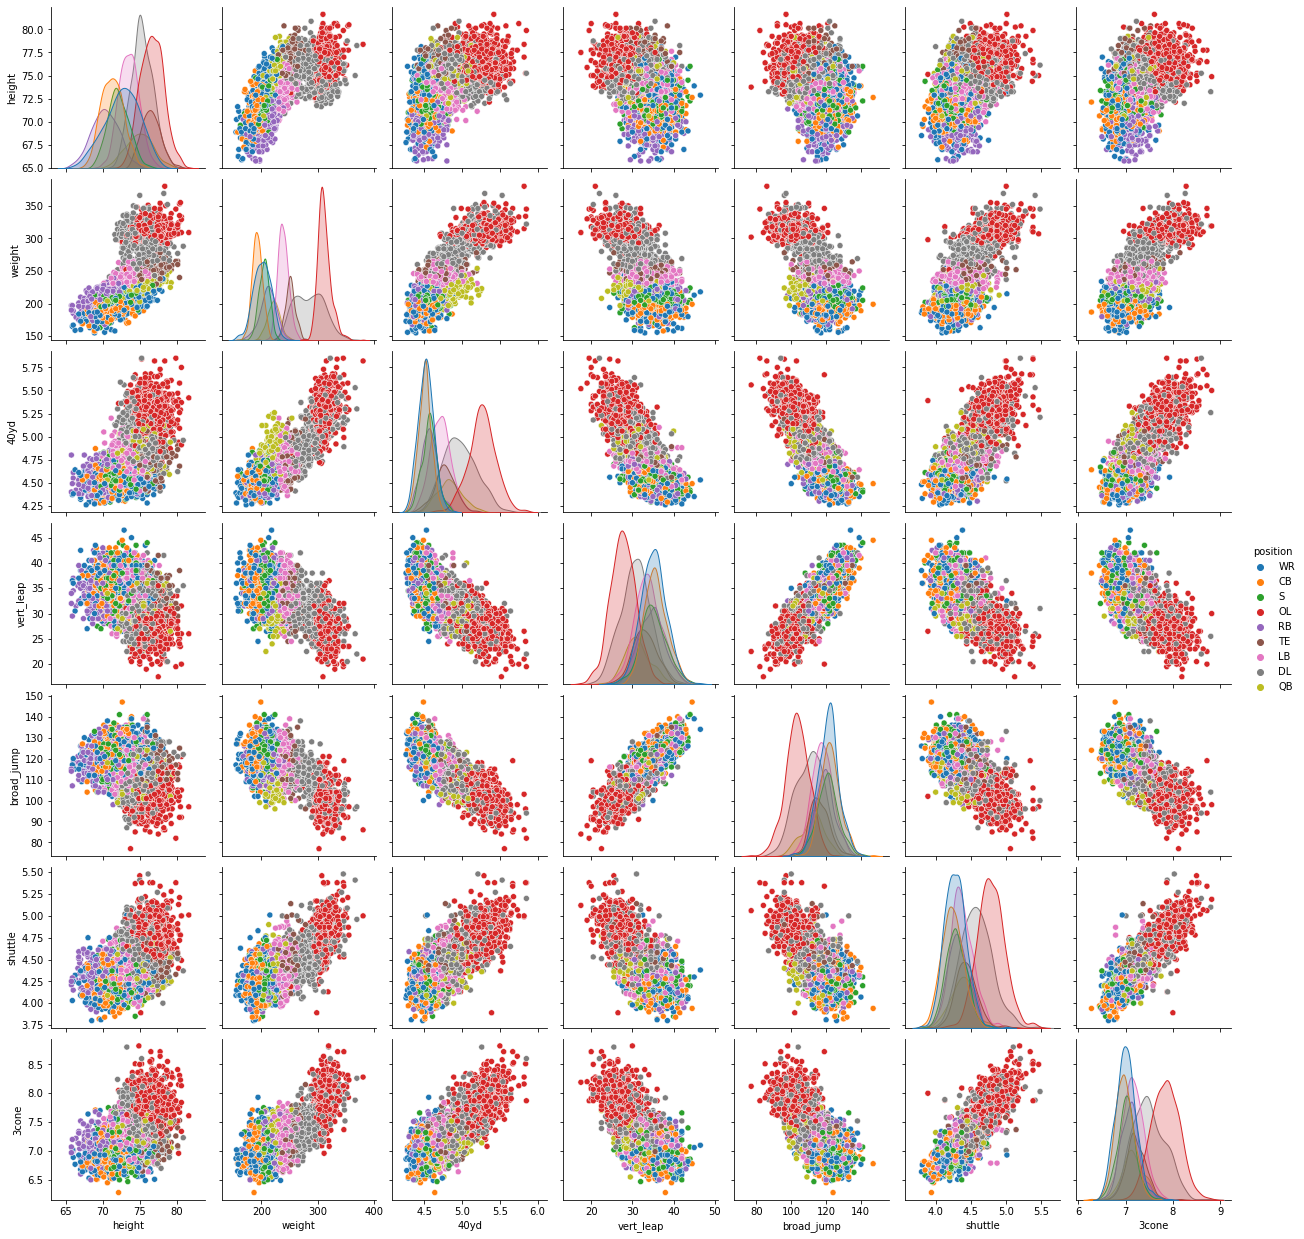

In [15]:
sns.pairplot(df[['position'] + features], hue='position')     # pairplot of data
plt.show()

We can see some general trends in this data and some groups of positions also seem evident.

## Decision Tree Classifier
To determine player positions based on our listed features (height, weight, 40yd, vert_leap, broad_jump, shuttle, and 3cone) we will use a supervised learning clustering method. Simply put, supervised learning methods can be used when when the "answer" is already known for the data. Explained better, we already know the position of each player in our data set so we can create a model to fit these known positions with the corresponding feature values (height, weigth, etc.). Since the positions are discrete values, we want to use a classifier model rather than a regressor (as regressors are used to predict continuous values).

An important part of creating a supervised learning method is training and testing our model. The original data set can be split into two portions
* a **training** set of data - a best fit model (given some hyperparameters) is made to fit this data
* a **testing** set of data - the accuracy of the model created using the training data is determined by running this data through the model. Here, the **modeled** clusters of the testing data are compared to the **actual** clusters of the testing data to look at the accuracy of the model.

The model I am choosing to illustrate here is the decision tree classifer. As mentioned above, this is a classifier model for supervised learning. Thus, a model will be created to return discrete values based on known data points. We discuss this model more below.

### Splitting testing and training data
Since we are now going to try a supervised clustering methods, we will need to split our data frame into a training set of data and a testing set of data. This will allow us to build a model with our four principal comonents (X_train) to explain position number (y_train). We will then test this model with the separated X_test data, explaining the y_test data.

To split the training and test data, we use the sklearn function train_test_split:
```python
X_train, X_test, y_train, y_test = train_test_split(independent_vars, dependent_var,
                                                    test_size=0.1, random_state=666)
```
As our independent variables (X_) we are using the different features of our data frame which we have listed above. The dependent variable in this model (y_) will be the differnet NFL positions. Here, we have separated out 10% of the data to be testing data (test_size=0.1).

In [16]:
# splitting our initial standardized DataFrame. We will use this going forward

X_train, X_test, y_train, y_test = train_test_split(df[features], df['pos_num'],
                                                    test_size=0.1, random_state=666)

We can visualize the two data sets using a pairplot.

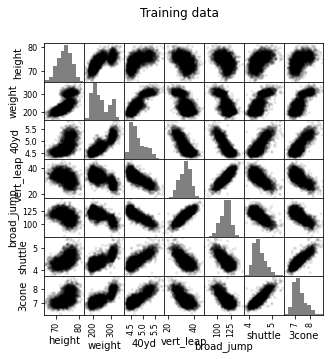

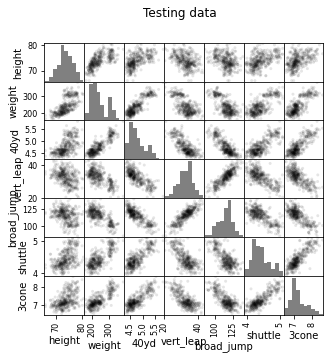

In [17]:
pd_plot.scatter_matrix(X_train[features], alpha = 0.1,
                       figsize=(5, 5), color = 'black', hist_kwds={'color':['grey']})  # training data
plt.suptitle('Training data')

pd_plot.scatter_matrix(X_test[features], alpha = 0.1,
                       figsize=(5, 5), color = 'black', hist_kwds={'color':['grey']})  # testing data
plt.suptitle('Testing data')

plt.show()

It looks like we sampled well based on the features (distributions look similar). Let's check our positions sampling.

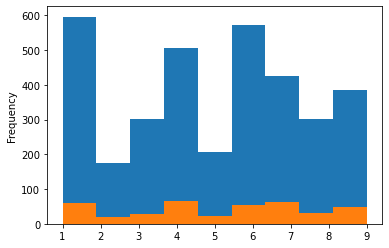

In [18]:
y_train.plot.hist(bins=9)    # training data positions
y_test.plot.hist(bins=9)     # testing data positions
plt.show()

This also looks like we sampled well on the data as the training and testing position lists seem to be of the same relative magnitude and we have testing and training data for each position.

Now let's save the training and testing data as arrays before we continue.

In [19]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Decision Tree Classifier
As defined in the scikit-learn documentation [here](https://scikit-learn.org/stable/modules/tree.html#tree), "decision trees are a non-parametric supervised learning method used for classification and regression". For this work, we will be using a descision tree to classify our samples by position. Our decision tree will be built based on our training data, and the accuracy of the tree will be measured on the testing data. Some terminology we will use:
* **Root node** - first node. This represents the entire populatiion
* **Splitting/branching** - making a choise between two options to get to a lower node
* **Decision node** - nodes below the root node that branch again (we don't really discuss this)
* **Leaf** - this is the terminal node or the last node in the decision tree
* **Branch** - the smaller decision tree that is made when focusing on a decision node and its corresponding nodes
* **Pruning** - removing leafs of the decision tree. This helps to simplify the model, removing overfit that may have occured
* **Tree depth** - steps/splits to get from the root node to a leaf

To initiate the formation of the decision tree classifier model, we simply use the command:
```python
clf = tree.DecisionTreeClassifier()     # initiating the decision tree classifier model
```
Where clf is just a placeholder name for the model. There are many optional parameters we can initiate the model with, but ones of interest further on include:
* **max_depth** - maximum depth of the tree (a smaller value will lead to a smaller tree)
* **max_leaf_nodes** - another way to limit the size of the tree by limiting the number of total nodes
* **ccp_alpha** - complexity parameter of tree. This is used for pruning the tree. We will start off with this at 0 and change the value once a **max_depth** or **max_leaf_nodes** has been chosen. As this value increases, more of the tree is pruned.
* **random_state** - controls the seed of any random values selected. I've set this just so my discussion stays consistent through different runs of the notebook.

Once a decision tree has been initiated, we can fit it to the training/testing data using:
```python
clf.fit(X_train, y_train)
```
When fitting the data, the *Gini impurity* criterion is used to determine the likelihood of incorrectly classifying a new, unknown variable. Where:

$H(Q_m) = \sum_{k} p_{mk}(1-p_{mk})$. More explanation on this classification as well as other discussion on decision trees can be found in the scikit-learn documentation in section *1.10.Decision Trees* [here](https://scikit-learn.org/stable/modules/tree.html#tree).

Additional discussion on the DecisionTreeClassifer can be found in the scikit-learn documentation secion *sklearn.tree.DecisionTreeClassifier* [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [20]:
clf = tree.DecisionTreeClassifier(random_state=666)     # initiating the decision tree classifier model
clf.fit(X_train, y_train)                               # fitting our model with input X to the output y

DecisionTreeClassifier(random_state=666)

Now that we have fit our decision tree to the training and testing data, we may be interested in what the actual tree looks like. We can print a text version of the tree with the following:
```python
r = tree.export_text(clf, feature_names=features)      # create decision tree (text version)
print(r)
```
Currently, running this command will give a very large tree that is difficult to scroll through and comprehend. Fortunately, we can get some additional information on our decision tree using built in methods. Without scrolling through the tree, we can find the total depth of the tree and the total number of leaves:
```python
clf.get_depth()             # total depth of decision tree
clf.get_n_leaves()          # total number of leaves of decision tree
```
Once we have knowledge of these two values, we can try pruning our tree. This will create a simpler model and will help to stay away from overfitting our data.

In [21]:
print(f'Depth of tree: {clf.get_depth()} \nNumber of leaves: {clf.get_n_leaves()}')

Depth of tree: 24 
Number of leaves: 973


Remembering the testing data we set aside, we can check the accuracy of the model with this data:
```python
clf.score(X_test, y_test)         # this is the initial accuracy of our decision tree with the testing data
```
It should be noted that since we are using a classifier, this only tells us the percentage of predictions this model gets completely correct.

In [22]:
print(f'Accuracy of model: {clf.score(X_test, y_test).round(3)}')         # this is the initial accuracy of our decision tree with the testing data

Accuracy of model: 0.526


### Pruning initial decision tree

Pruning our decision tree will help to simplify the decision tree model. By making the model less complex through pruning, we hope to decrease the model variance. Pruning our decision tree will remove end leaves from our decision tree to create a more simple decision tree model. This will be done by changing the **ccp_alpha** value called when creating the model.

We will follow the work laid out in the scikit-learn documentation [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py). More details, including graphic examples can be found at the previous link. I will walk through the important steps which we can use to determine the ccp_alpha value which will lead to pruning.

Within the DecisionTreeClassifier class, scikit-learn provides a method **cost_complexity_pruning_path** which gives information of the effective alpha values at each step of the pruning process. (The total impurity of the leaves is also included here but we are uninterested in this for now). To get a list of the alpha values we can do the following:

The following lines of code follow the workflow in the scikit-learn documentation *Post pruning decision trees with cost complexity pruning* found [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py).
```python
path = clf.cost_complexity_pruning_path(X_train, y_train)       # creates variable containg alpha and impurity values
ccp_alphas = path.ccp_alphas                                    # alpha values at each pruning step
```

We now have a list of the different alpha values that we can prune with. As our alpha value gets larger, we will prune more and more of the tree. Using the largest alpha value (ccp_alphas[-1]) to prune the tree will result in a tree with only one node left.

For each alpha value, we will create a new DecisionTreeClassifier model. Each of these models will be appended into a list of models:
```python
clfs = []                          # creates a list of the ccp values to work with
for ccp_alpha in ccp_alphas:       # creates a new model for each alpha value
    clf = tree.DecisionTreeClassifier(random_state=666, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)      # fits training data to model
    clfs.append(clf)               # add model to list of models
```

Now that we have a list of all the pruned model, we can determine the model score. Remember that since we are using a classifier (rather than regression) the model score only tells us percentage of values modeled correctly. Although we are more interested in how the testing data performs (testing data score) we will also calculate the training data score for each alpha value.
```python
train_scores = [clf.score(X_train, y_train) for clf in clfs]    # list of accuracy for training data
test_scores = [clf.score(X_test, y_test) for clf in clfs]       # list of accuracy for testing data
```

We'll code this up as one function to return a list of training and testing scores below.

In [23]:
# input decision tree model (above we have called this clf)
# input the training data and testing data as well to calculate the training and testing scores
# returns a list of alpha values and the associated training scores and testing scores

def scores_for_changing_alpha(decision_tree_model, X_train, y_train, X_test, y_test):
    
    clf = decision_tree_model                # doing this so the rest of the function matches the markdown notes
    
    path = clf.cost_complexity_pruning_path(X_train, y_train)  # creates variable containg alpha and impurity values
    ccp_alphas = path.ccp_alphas                               # alpha values at each pruning step
    
    clfs = []                                 # creates a list of the ccp values to work with
    
    for ccp_alpha in ccp_alphas:              # creates a new model for each alpha value
        clf = tree.DecisionTreeClassifier(random_state=666, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)             # fits training data to model
        clfs.append(clf)                      # add model to list of models
        
    train_scores = [clf.score(X_train, y_train) for clf in clfs]    # list of accuracy for training data
    test_scores = [clf.score(X_test, y_test) for clf in clfs]       # list of accuracy for testing data
    
    return [ccp_alphas, train_scores, test_scores]

We can now get a list of the possible alpha values and the corresponding training and testing scores by calling this function:
```python
ccp_alphas   = scores_for_changing_alpha(clf, X_train, y_train, X_test, y_test)[0]
train_scores = scores_for_changing_alpha(clf, X_train, y_train, X_test, y_test)[1]
test_scores  = scores_for_changing_alpha(clf, X_train, y_train, X_test, y_test)[2]
```
This will allow us to visuallize the data as well as calculate the best alpha value to use.

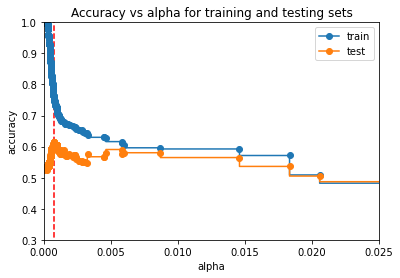

In [24]:
alpha_train_test = scores_for_changing_alpha(clf, X_train, y_train, X_test, y_test)
ccp_alphas       = alpha_train_test[0]
train_scores     = alpha_train_test[1]
test_scores      = alpha_train_test[2]

plt.step(ccp_alphas, train_scores, marker="o", label="train")
plt.step(ccp_alphas, test_scores, marker="o", label="test")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.xlim(0, 0.025)
plt.ylim(0.3, 1)   # zoomed in to better see maximum test accuracy
plt.vlines(0.000762, 0, 1, colors='r', linestyles='dashed')    # line showing where alpha value maximizes testing data accuracy
plt.legend()
plt.show()

Interestingly, the highest accuracy for for the testing set is not when alpha = 0! This means we initially overfit the data. Since increasing alpha will lower the complexity of the model, we want to use the highest value of alpha while keeping a high accuracy in our testing data. To do so, we will find the alpha value where **test_scores** is maximized and then use the maximum alpha value of these.

In [25]:
# calculates the maximum alpha value when test_scores is also maximized
alpha_best = ccp_alphas[max(np.argwhere(test_scores == np.amax(test_scores)))[0]]

print(f'Alpha value leading to highest accuracy is: {alpha_best.round(6)}')

Alpha value leading to highest accuracy is: 0.000762


We can now rerun our model with this alpha value to see how our decision tree is impacted. We already know that this increased alpha value should increase the accuracy of our training data (although it has lowered the accuracy of the training data).

In [26]:
clf_new = tree.DecisionTreeClassifier(random_state=666, ccp_alpha=alpha_best)   # re-initiate tree
clf_new.fit(X_train, y_train)                                                   # re-create tree

print(f'Testing score: {clf_new.score(X_test, y_test).round(3)} \n'
      f'Depth of tree: {clf_new.get_depth()} \n'
      f'Number of leaves: {clf_new.get_n_leaves()}')

Testing score: 0.614 
Depth of tree: 12 
Number of leaves: 120


We've raised the accuracy of this prediction from 52.6% to 61.4% just by pruning the tree! In addition we have lowered the depth of the tree from 24 to 12 and lowered the total number of leaves from 973 to 120. This tree can be more easily visualize and has an increased accuracy.

To visualize the tree we can do the following **(double click image to see full size)**:

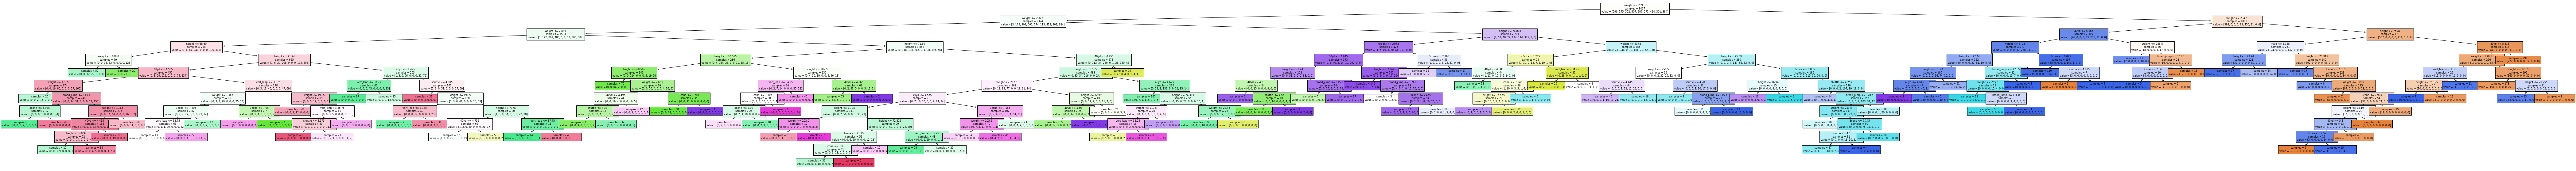

In [27]:
fig = plt.figure(figsize=(150,10))
tree.plot_tree(clf_new,
               feature_names=list(features),
               filled=True,
               impurity=False,
               fontsize=8
              )
plt.show()

Within the zoomed in image, at a leaf, the final position correlates to the index of the maximum number in the "value" list. For example:<br>
[0, 0, 4, 5, 0, 0, 0, 3, 23] is a position #9 or a corner back.

As text this can be visualized as:

In [28]:
r = tree.export_text(clf_new, feature_names=features)      # create decision tree (text version)
print(r)

|--- weight <= 259.50
|   |--- weight <= 226.50
|   |   |--- weight <= 200.50
|   |   |   |--- height <= 68.69
|   |   |   |   |--- weight <= 188.00
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- weight >  188.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- height >  68.69
|   |   |   |   |--- height <= 71.94
|   |   |   |   |   |--- 40yd <= 4.54
|   |   |   |   |   |   |--- weight <= 179.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- weight >  179.50
|   |   |   |   |   |   |   |--- broad_jump <= 113.50
|   |   |   |   |   |   |   |   |--- 3cone <= 6.98
|   |   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |   |   |--- 3cone >  6.98
|   |   |   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |   |   |--- broad_jump >  113.50
|   |   |   |   |   |   |   |   |--- weight <= 194.50
|   |   |   |   |   |   |   |   |   |--- 40yd <= 4.41
|   |   |   |   |   |   |   |   |   |   |--- height <= 69.94
|   |   |   |   |   |   

### Optimizing starting tree

Since we investigating tree pruning and trying to use a small tree so we don't overfit data, let's see what happens when we start with a smaller tree. To do this, we will go to the scikit-learn's model_selection.GridSearchCV.  This uses cross validation to cycle through multiple lists of paramets and return the best parameters for a given model. We will begin by initiating our model decision tree model as before:
```python
clf = tree.DecisionTreeClassifier(random_state=666)     # initiating the decision tree classifier model
```

We can then list out the parameters and the values of the parameters we wish to test. I only want to look at the maximum depth of the tree, but addition parameters and ranges could be added to this "parameter dictionary".
```python
parameters = {'max_depth':range(1,24)
             }
```

The GridSearchCV is then initiated using a 10-fold cross validation method (cv=10). Cross validation is used instead of a single random sample of training and testing data to get more distributions of training and testing data.
```python
grid = GridSearchCV(clf, parameters, cv=10, scoring='accuracy')
```

Since we are using 10-fold cross validation, when we fit this model we want to use all of our data, not just the training set as done before.
```python
grid.fit(df[features], df['pos_num'])
```

From here, the model can be accessed similar to before using "grid.PARAMETER". Additional information can be found in the scikit-learn documentation section on *GridSearchCV* [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [29]:
clf = tree.DecisionTreeClassifier(random_state=666)     # initiating the decision tree classifier model

parameters = {'max_depth':range(1,24)       # interested in testing maximum depths from 1 to 23
             }

grid = GridSearchCV(estimator=clf,                # estimator to use - for us, DecisionTreeClassifier
                    param_grid=parameters,        # parameters to test
                    cv=10,                        # 10-fold cross validation
                    scoring='accuracy'            # scoring type - for us, checking accuracy of model
                   )                              # initiating grid cross validation

grid.fit(df[features], df['pos_num'])                           # fitting to all data

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=666),
             param_grid={'max_depth': range(1, 24)}, scoring='accuracy')

We can now fine the best score and the max_depth paramter used to get this score. If we chose to test more parameters, they would also be returned along with the max_depth value. However, additional paramters would add to the time of the above function as each unique parameter combination is tested with GridSearchCV.

In [30]:
print(f'Top grid score: {grid.best_score_.round(3)} \n'
      f'{grid.best_params_}')

Top grid score: 0.615 
{'max_depth': 7}


We now know that our ideal max_depth is 7. From here, let's go back through the pruning workflow in an attempt to better our model. As a reminder, we may end up with a lower accuracy than 0.615 since we are going back to the training/testing data split that we initially created.

In [31]:
clf_7 = tree.DecisionTreeClassifier(random_state=666, max_depth=7)     # initiating the decision tree classifier model
clf_7.fit(X_train, y_train)                               # fitting our model with input X to the output y

print(f'Testing score: {clf_7.score(X_test, y_test).round(3)} \n'
      f'Depth of tree: {clf_7.get_depth()} \n'
      f'Number of leaves: {clf_7.get_n_leaves()}')

Testing score: 0.593 
Depth of tree: 7 
Number of leaves: 113


We aer slightly less accurate than our previously pruned tree, but the accuracy of our prediction is nearly 60%. In addition our tree depth is 7 and the model tree has 113 leaves.

We can also prune this tree to remove any additional overfit, increasing the accuracy of our prediction.

Testing score: 0.604 
Depth of tree: 7 
Number of leaves: 69


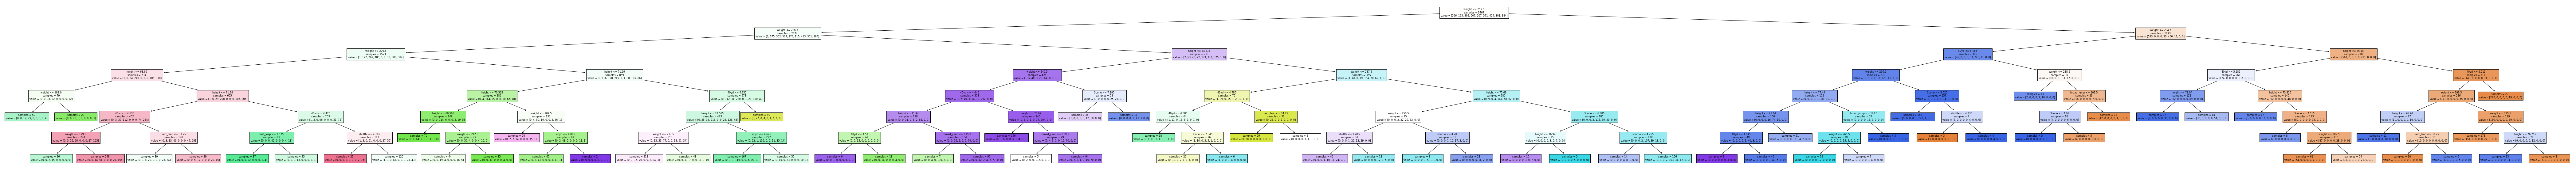

In [32]:
alpha_train_test = scores_for_changing_alpha(clf_7, X_train, y_train, X_test, y_test)
ccp_alphas       = alpha_train_test[0]
train_scores     = alpha_train_test[1]
test_scores      = alpha_train_test[2]

clf_new = tree.DecisionTreeClassifier(random_state=666, max_depth=7, ccp_alpha=alpha_best)   # re-initiate tree
clf_new.fit(X_train, y_train)                                                  # re-create tree

print(f'Testing score: {clf_new.score(X_test, y_test).round(3)} \n'
      f'Depth of tree: {clf_new.get_depth()} \n'
      f'Number of leaves: {clf_new.get_n_leaves()}')

fig = plt.figure(figsize=(150,10))
tree.plot_tree(clf_new,
               feature_names=list(features),
               filled=True,
               impurity=False,
               fontsize=8
              )
plt.show()

*Double click above figure to zoom in on full tree.*

The final pruning of the decision tree returns a model with a depth of 7 and 69 leaves. The accuracy of this model is just over 60%. This is very close to the accuracy of the initial pruned decision tree, however, we have used a much smaller decision tree to make this prediction.

## Results

As we have seen, by pruning our decision tree, we can reduce the overfit of our model. By tuning the decision tree hyperparameters, specifically max_depth, we were able to increase the base accuracy of the model. Pruning this model again increased the model accuracy. Although this pruned max_depth model did not have quite as high of an accuracy as the pruned full model, the number of leaves and the overall tree depth were much smaller than even the pruned full model. The testing scores, depth of tree, and number of leaves are summarized below.

| | Testing score | Depth of tree | Number of leaves |
| --- | --- | --- | --- |
| **Full Tree** | | | |
| unpruned | 0.526 | 24 | 973 |
| pruned | 0.614 | 12 | 120 |
| **max_depth=7** | | | |
| unpruned | 0.593 | 7 | 113 |
| pruned | 0.604 | 7 | 69 |

Since the the tree has effectively been pruned by limiting the total depth of the decision tree (max_depth=7), going through the pruning process does not increase the accuracy of the decision tree by as much as it did for the full tree. However, we still drop around 40% of the leaves through pruning, making the final decision tree much easier to visualize as we have shown above.

In general, this methodology can be used for any data set that can be split discretely into classes. We see that tuning the max_depth hyperparameter followed by pruning can greatly decrease the final tree size of the model without losing too much of the model accuracy.

#### Looking at our specific data set (for NFL positions)

This workflow has shown how pruning and hyperparameter selection can aid in creating a more accurate and smaller decision tree. Just for interest of our specific model data, I am interested in how well the model predicted the NFL data position by position. The following block of code looks at the actual testing positions vs the positions predicted using the testing data.

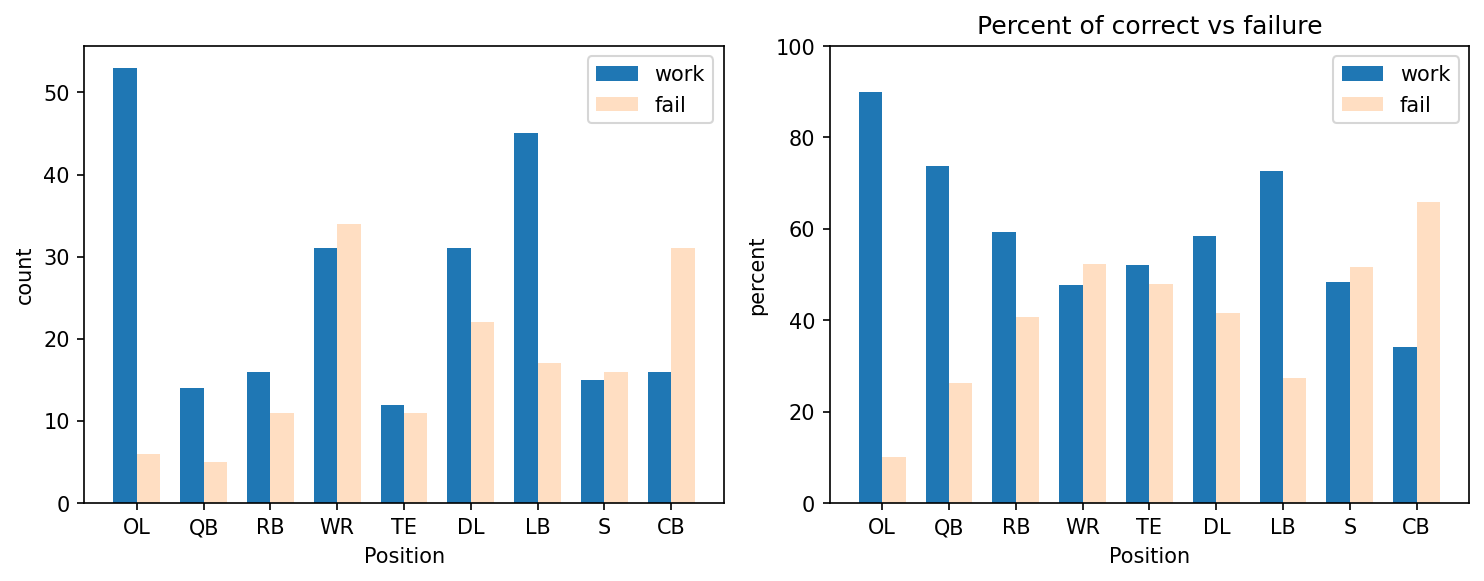

In [33]:
# The following is work to split the successful predictions from the unsuccessful (failed) predictions.

diff = clf_new.predict(X_test) - y_test             # difference between predicted and actual position

# make a list of 0s (positions equal) and 1s (positions are different) from the difference list above
equal_list = diff.copy()
equal_list[equal_list != 0] = 1

# make a data frame of the actual value, predicted value, and the 'equal_list'
d_learn_output = {'test': y_test, 'pred': clf_new.predict(X_test), 'eq': equal_list}
df_learn_output = pd.DataFrame(data=d_learn_output)

# separate into 2 lists of working results and failures
df_learn_work = df_learn_output.copy()
df_learn_fail = df_learn_output.copy()
df_learn_work.drop(df_learn_work.loc[df_learn_work['eq']==1].index, inplace=True)
df_learn_fail.drop(df_learn_fail.loc[df_learn_fail['eq']==0].index, inplace=True)

# list of positions and associated numbers for graphing purposes
pos_list = ['OL', 'QB', 'RB', 'WR', 'TE', 'DL', 'LB', 'S', 'CB']
pos_list_num = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# count failures and working cases
work_count = np.zeros(len(pos_list_num))
fail_count = np.zeros(len(pos_list_num))
for i in pos_list_num:
    work_count[i-1] = df_learn_work[(df_learn_work.test == i)].count()['eq']
    fail_count[i-1] = df_learn_fail[(df_learn_fail.test == i)].count()['eq']


work = work_count
fail = fail_count
np.seterr(divide='ignore', invalid='ignore')      # makes error not show up when dividing by 0
work_pct = work_count / (work_count + fail_count)
fail_pct = fail_count / (work_count + fail_count)

x = np.arange(len(pos_list))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(x - width/2, work, width, label='work')
ax[0].bar(x + width/2, fail, width, alpha=0.25, label='fail')
ax[0].set_ylabel('count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(x)
ax[0].set_xticklabels(pos_list)
ax[0].legend()

ax[1].bar(x - width/2, work_pct*100, width, label='work')
ax[1].bar(x + width/2, fail_pct*100, width, alpha=0.25, label='fail')
ax[1].set_ylabel('percent')
ax[1].set_xlabel('Position')
ax[1].set_xticks(x)
ax[1].set_xticklabels(pos_list)
ax[1].set_ylim(0,100)
ax[1].set_title('Percent of correct vs failure')
ax[1].legend()

fig.tight_layout()
fig.set_dpi(150)

plt.show()

This is more a point of interest specific to this study, but it looks like offensive line, quarterback, and linebackers (OL, QB, LB) were the most successfully predicted positions in the withheld testing set. Wide receivers, safeties, and especially corner backs (WR, S, CB) were not predicted as well, each with prediction accuracies below 50%. This may be due to the similarity in the player sizes of these positions.

As a note on this model, the tree splits are based off of college/NFL athletes. However, if you took the additional step to standardize the data before creating the decision tree model, the same model could be used to determine positions for a kindergarten football team.

## Resources used

NFL combine data was compiled using data from https://nflcombineresults.com/nflcombinedata.php

As linked within my workflow, the documentation for scikit-learn was very helpful when working with the decision tree classification model, completing cost complexity pruning, and completing cross-validation with GridSearchCV.

#### Citation
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

## Parting Comments
This code was a fun way to work through the some basic clustering algorithms and to look a little at decision trees. It is interesting trying to predict NFL positions purely based on physical attributes and on the results of a few tests. Although some players will switch positions once they arrive to the NFL (due to their size or team needs) players will often continue to play the position they are most comfortable with from college and high school.

Maybe some intermural team of all non-football players can use this workflow to determine what position they should each play in a pickup game. It also might be better to first determine who can throw the ball the best and make them the quarterback.


I hope this was helpful,

*Olin Carty*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
